<a href="https://colab.research.google.com/github/TectoArc/Carbon-Predictions/blob/main/MC_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

sns.set_style("dark")
plt.style.use("ggplot")
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [15]:
df = pd.read_excel("Dataset P.xlsx", skiprows=1)
data = df.copy()
data = data.drop(columns = ["Reference","Sample Number","Unnamed: 4","Unnamed: 7",
                            "Unnamed: 10","Unnamed: 13","Unnamed: 16"], axis=1)
print(data.shape, data.columns)

df_train = pd.read_excel("Dataset_M.xlsx", skiprows=1)
df_train = df_train.drop(columns=["Reference","Sample Number"], axis=1)
print(df_train.shape, df_train.columns)

(336, 12) Index(['Pressure (Gpa)', 'δP', 'Temperature (°C)', 'δT', 'Fe', 'δFe', 'Ni',
       'δNi', 'S', 'δS', 'C', 'δC'],
      dtype='object')
(336, 6) Index(['Pressure (Gpa)', 'Temperature (°C)', 'Fe', 'Ni', 'S', 'C'], dtype='object')


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor


X  = df_train.drop('C', axis = 1)
y = df_train['C']

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_extr = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                    max_depth=32, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=500, n_jobs=None, oob_score=False,
                    verbose=0, warm_start=True, random_state=100)

y_extr = model_extr.fit(X_train_scaled, y_train).predict(X_test_scaled)
X_scale = scaler.transform(X)
y_pred_extr = model_extr.predict(X_scale)

In [17]:
N=1000
data_MCP = pd.DataFrame()
predictions = np.empty([len(df_train),N])
for i in range(0,N):
  data_MCP["MCP"]= np.random.uniform(data["Pressure (Gpa)"]-data["δP"], data["Pressure (Gpa)"]+data["δP"])
  data_MCP["MCT"]= np.random.uniform(data["Temperature (°C)"]-data["δT"], data["Temperature (°C)"]+data["δT"])
  data_MCP["MCFe"]= np.random.uniform(data["Fe"]-data["δFe"], data["Fe"]+data["δFe"])
  data_MCP["MCNi"]= np.random.uniform(data["Ni"]-data["δNi"], data["Ni"]+data["δNi"])
  data_MCP["MCS"] = np.random.uniform(data["S"]-data["δS"], data["S"]+data["δS"])

  data_MCP_norm = scaler.transform(data_MCP)
  predictions[:,i] = model_extr.predict(data_MCP_norm)

noise = predictions[:,0]
for i in range(1,N):
  noise = np.append(noise, predictions[:,i])

## Calculation std , mean , max and min for Carbon predicted values 

carbon_mean_pred = np.empty(len(predictions))
carbon_std_pred = np.empty(len(predictions))
carbon_min_pred = np.empty(len(predictions))
carbon_max_pred = np.empty(len(predictions))
for i in range(0,len(predictions)):
  carbon_mean_pred[i] = np.mean(predictions[i,:])
  carbon_std_pred[i] = 2 * np.std(predictions[i,:])
  carbon_min_pred[i] = np.min(predictions[i,:])
  carbon_max_pred[i] = np.max(predictions[i,:])

df2 = data.copy()
df2["Carbon_Mean"] = carbon_mean_pred
df2["Carbon_Error"] = carbon_std_pred 

df2.to_excel("MC Output.xlsx", index=False)

In [18]:
s = pd.read_excel("MC Output.xlsx")
s.head()

,Pressure (Gpa),δP,Temperature (°C),δT,Fe,δFe,Ni,δNi,S,δS,C,δC,Carbon_Mean,Carbon_Error
0,0.001,0.0,1200,24.0,88.551165,0.2,7.598784,0.4,0.0,0.0,3.850051,0.38,3.553804,0.023513
1,0.001,0.0,1250,25.0,87.860082,0.4,8.436214,0.3,0.0,0.0,3.703704,0.36,3.409527,0.117494
2,0.001,0.0,1280,25.6,86.317907,0.2,10.362173,0.5,0.0,0.0,3.319920,0.33,3.122856,0.149527
3,0.001,0.0,1310,26.2,88.016113,0.2,8.962739,0.2,0.0,0.0,3.021148,0.30,2.936565,0.267225
4,0.001,0.0,1360,27.2,89.032901,0.2,8.574277,0.2,0.0,0.0,2.392822,0.24,2.542732,0.236370


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


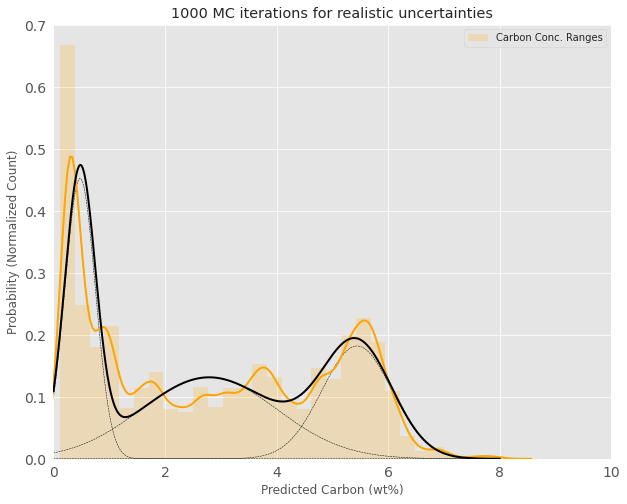

In [19]:
from sklearn.mixture import GaussianMixture

x = np.linspace(0,8, 1000)
n = np.arange(1,4)

result = noise.reshape(-1,1)
models = [None for i in range(len(n))]

for i in range(len(n)):
  models[i] = GaussianMixture(n[i]).fit(result)

AIC = [m.aic(result) for m in models] 
BIC = [m.bic(result) for m in models]

best_score = models[np.argmin(AIC)]

log_prob = best_score.score_samples(x.reshape(-1,1))
probs = best_score.predict_proba(x.reshape(-1,1))
final_prob = np.exp(log_prob)
individual_prob = probs*final_prob[:,np.newaxis]

fig = plt.figure(figsize=(10,8))
sns.distplot(noise, hist=True, kde=True, bins=30, color='orange', 
             hist_kws={'edgecolor':'None','alpha':0.2,'zorder':2},
             kde_kws={'linewidth': 2, 'zorder':4}, label="Carbon Conc. Ranges")

plt.plot(x, final_prob,"-", color='k', lw=2, zorder=5)
plt.plot(x, individual_prob,'k--',lw=0.5, zorder=2)

plt.xlabel("Predicted Carbon (wt%)")
plt.ylabel("Probability (Normalized Count)")
plt.title("1000 MC iterations for realistic uncertainties")
plt.legend(loc="upper right", fontsize="medium")
plt.xlim(0,10)
#fig.savefig("MC_result.jpg", format="jpg", dpi=1600)
plt.show()